In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from mymodules.bcfmodel import BcfModel
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryConfusionMatrix
# from myutils.mydataset import MyDataset
from myutils.myutils import draw_score_loss
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

c:\Users\KDP-38\anaconda3\envs\TORCH_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

In [4]:
# 사전 훈련된 BERT 모델과 토크나이저 로드
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

c:\Users\KDP-38\anaconda3\envs\TORCH_38\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.

In [5]:
class MyDataset(Dataset):
    def __init__(self,featureDF,targetDF) -> None:
        super().__init__()
        # self.DF = DF
        self.targetDF = targetDF
        self.featureDF = featureDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values).to(self.device)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values).to(self.device)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [6]:
dataDF = pd.read_csv('./DATA/MBTI.csv')

In [ ]:
# labels = dict(zip(dataDF['type'].unique().tolist(),range(16)))
# dataDF['type'] = dataDF['type'].map(lambda x:labels[x])

In [14]:
sampled_df = dataDF.groupby('type', group_keys=False).apply(lambda x: x.sample(n=181, random_state=42))
sampled_df['type'].value_counts()

type
ENFJ    181
ENFP    181
ENTJ    181
ENTP    181
ESFJ    181
ESFP    181
ESTJ    181
ESTP    181
INFJ    181
INFP    181
INTJ    181
INTP    181
ISFJ    181
ISFP    181
ISTJ    181
ISTP    181
Name: count, dtype: int64

In [74]:
dataDF = dataDF.drop(columns=dataDF.columns[0])

In [27]:
dataDF['posts'].to_numpy()

<function ndarray.reshape>

In [8]:
sampled_df['type'] = sampled_df['type'].str.contains('N').astype('int8')

In [15]:
result = pd.DataFrame()

In [8]:
def preprocess_function(word):
    return tokenizer(word, truncation=True, padding='max_length', max_length=5)['input_ids']

In [16]:
for index, row in sampled_df.iterrows():
    # 각 행의 단어를 분리
    features = row['posts'].split()
    # 해당 단어에 맞는 타겟 값 생성
    targets = [row['type']] * len(features)
    
    # 결과 데이터프레임에 추가
    dfs = pd.DataFrame({'features' : features, 'targets':targets})
    result = pd.concat([result, dfs], ignore_index=True)

In [17]:
result

,features,targets
0,hug,ENFJ
1,kiss,ENFJ
2,touch,ENFJ
3,etc,ENFJ
4,thing,ENFJ
...,...,...
1450316,revision,ISTP
1450317,ibrahim,ISTP
1450318,ghoshesh,ISTP
1450319,wish,ISTP


In [107]:
encodings = tokenizer(list(result['features']), truncation=True, padding=True, return_tensors="pt")
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

In [128]:
# 임베딩 생성 (여기서는 간단히 input_ids의 평균을 사용)
input_embeddings = pd.DataFrame(input_ids.float().mean(dim=1))  # 각 문장의 평균 임베딩
targetDF = result[['targets']]

In [82]:
featureDF = result.drop(columns='label')
targetDF = result[['label']]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(input_embeddings,targetDF,stratify=targetDF, test_size=0.2, random_state=42)

In [130]:
X_train

,0
58139,249.882355
66451,159.294113
63623,140.000000
68834,316.117645
18756,179.882355
...,...
10116,171.411758
26055,389.117645
58521,210.882355
46809,209.823532


In [41]:
from datasets import Dataset
dataset2 = Dataset.from_pandas(result)

c:\Users\KDP-38\anaconda3\envs\TORCH_38\lib\site-packages\datasets\table.py:720: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  return cls(pa.Table.from_pandas(*args, **kwargs))


In [42]:
def preprocess_function(examples):
    return tokenizer(examples['word'], truncation=True, padding='max_length', max_length=5)

In [43]:
tokenized_dataset = dataset2.map(preprocess_function, batched=True)

Map:   0%|          | 0/80143 [00:00<?, ? examples/s]


KeyError: 'word'

In [ ]:
tokenized_dataset['feature']

In [69]:
from transformers import EarlyStoppingCallback

In [ ]:
# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# 훈련 설정
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 모델 훈련
trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_dataset)
pred_labels = predictions.predictions.argmax(-1)
print(pred_labels)

In [131]:
class BcfModel(nn.Module):
    # 모델구조 구성 및 인스턴스 생성 메서드
    def __init__(self,in_in,* in_out):
        super().__init__()
        self.in_layer = nn.Linear(in_in,in_out[0])
        self.h_layer = nn.ModuleList([nn.Linear(in_out[i],in_out[i+1]) for i in range(len(in_out)-1)])
        self.out_layer = nn.Linear(in_out[-1],1)

    # 순방향 학습 진행 메서드
    def forward(self,x):
        y=self.in_layer(x)      # f1w1 + f2w2 + f3w3 + b 결과 10
        y=F.relu(y)             # 0 <= y
        for layer in self.h_layer:
            y=layer(y)
            y=F.relu(y)
        return F.sigmoid(self.out_layer(y))         # 2진분류 출력층은 sigmoid() 액티베이션 펑션 활성화 함수

In [132]:
bcfmodel = BcfModel(1,800,600,400,200)

In [133]:
trainDS = MyDataset(X_train,y_train)
valDS = MyDataset(X_test,y_test)

In [134]:
EPOCHS = 10
BATCH_SIZE = batch_size=X_train.shape[0]//100
LR = 0.01

In [135]:
trainDL = DataLoader(trainDS,BATCH_SIZE)

In [136]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer = optim.Adam(bcfmodel.parameters(),lr=LR)

# 손실함수 인스턴스 => 분류 => 2진분류 BinaryCrossEntropyLoss => BCELoss()
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리후 전달
regLoss = nn.BCELoss()

In [137]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
BREAK_SCORE_CNT = 0
BREAK_LOSS_CNT = 0
for epoch in range(EPOCHS):
    # 학습 모드로 모델 설정
    bcfmodel.train()
    # 배치크기만큼 데이터 로딩해서 학습
    total_loss, total_score = 0,0
    for featureTS, targetTS in trainDL:
        # 학습 진행
        y_pre = bcfmodel(featureTS)

        # 손실 계산
        loss = regLoss(y_pre,targetTS)
        total_loss += loss.item()

        # 성능평가 계산
        score = BinaryF1Score()(y_pre,targetTS)
        total_score += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    bcfmodel.eval()
    with torch.no_grad():
        # 검증데이터셋
        val_feature = valDS[:][0]
        val_target = valDS[:][1]

        # 추론 / 평가
        pre_val = bcfmodel(val_feature)

        # 손실
        loss_val=regLoss(pre_val,val_target)
        
        # 성능평가
        score_val=BinaryF1Score()(pre_val,val_target)

    # 손실값과 성능악악값 저장
    LOSS_HISTORY[0].append(total_loss/len(trainDL))
    SCORE_HISTORY[0].append(total_score/len(trainDL))
    LOSS_HISTORY[1].append(loss_val.item())
    SCORE_HISTORY[1].append(score_val.item())
    if len(LOSS_HISTORY[1]) >= 2:
        if LOSS_HISTORY[1][-1] >= LOSS_HISTORY[1][-2]:
            BREAK_LOSS_CNT +=1
            
    # Score기준
    if len(SCORE_HISTORY[1]) >= 2:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]:
            BREAK_SCORE_CNT +=1 
    print(f'EPOCH: {epoch}, score: {SCORE_HISTORY[1][-1]}, loss: {LOSS_HISTORY[1][-1]}')
    # 학습중단 여부 설정
    if (BREAK_LOSS_CNT >= 20) or (BREAK_SCORE_CNT >= 20):
        if BREAK_LOSS_CNT >= 20:print(f'LOSS 변화 없음 EPOCH 종료 (epoch: {epoch})')
        else : print(f'SCORE 변화 없음 EPOCH 종료 (epoch: {epoch})')
        break

EPOCH: 0, score: 0.0, loss: 49.92201614379883
EPOCH: 1, score: 0.0, loss: 49.92201614379883
EPOCH: 2, score: 0.0, loss: 49.92201614379883
EPOCH: 3, score: 0.0, loss: 49.92201614379883
EPOCH: 4, score: 0.0, loss: 49.92201614379883
EPOCH: 5, score: 0.0, loss: 49.92201614379883
EPOCH: 6, score: 0.0, loss: 49.92201614379883
EPOCH: 7, score: 0.0, loss: 49.92201614379883
EPOCH: 8, score: 0.0, loss: 49.92201614379883
EPOCH: 9, score: 0.0, loss: 49.92201614379883


테스트 로스: 0 테스트 점수: 0


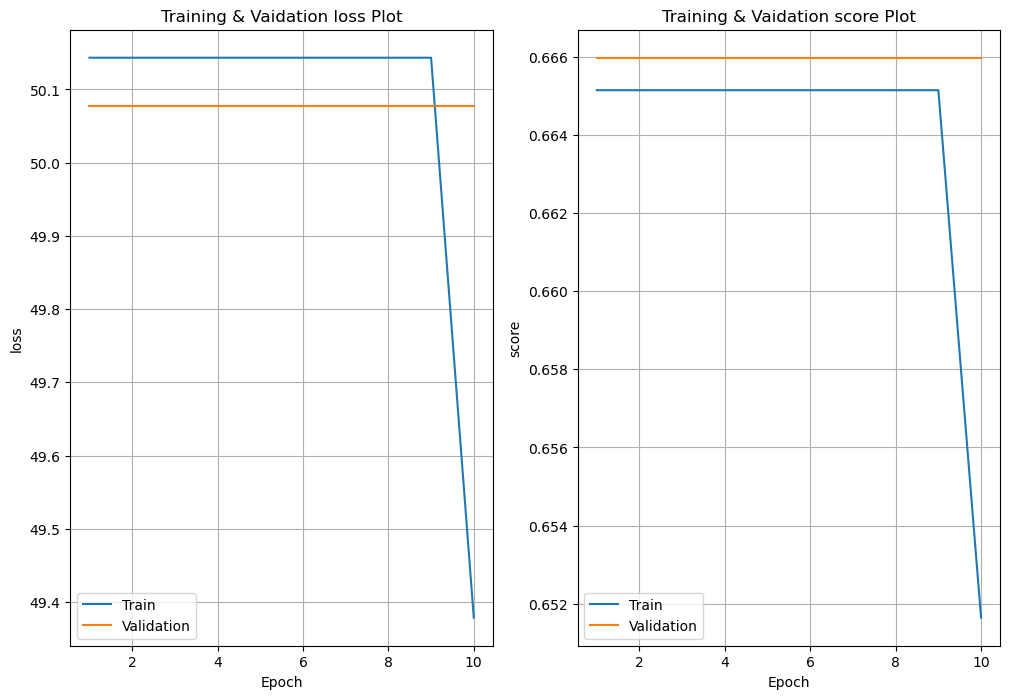

In [64]:
draw_score_loss(LOSS_HISTORY,SCORE_HISTORY)